# Imports

In [ ]:
!pip install torcheval
!pip install torchinfo
!pip install torchvision

In [ ]:
import argparse
import logging
import sys
from pathlib import Path
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchvision import transforms
from torcheval.metrics.classification import MulticlassRecall
from torcheval.metrics import MulticlassPrecision
from torchinfo import summary
from torchvision import models
import numpy as np
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from torchsummary import summary
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

csv_dir = '/content/drive/MyDrive/Dataset/new_train_lable.csv'
img_dir = '/content/drive/MyDrive/Dataset/Train/'
mean = [0.5401, 0.5045, 0.4845]
std = [0.2259, 0.2270, 0.2279]
dir_checkpoint = Path('weights')
dir_checkpoint.mkdir(parents=True, exist_ok=True)
classes = ("benign", "malignant")

Mounted at /content/drive/


# Custom Dataset Class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name + '.tif')

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        class_label = torch.tensor(self.data.iloc[idx, 1])
        sample = {'image': image, 'class': class_label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

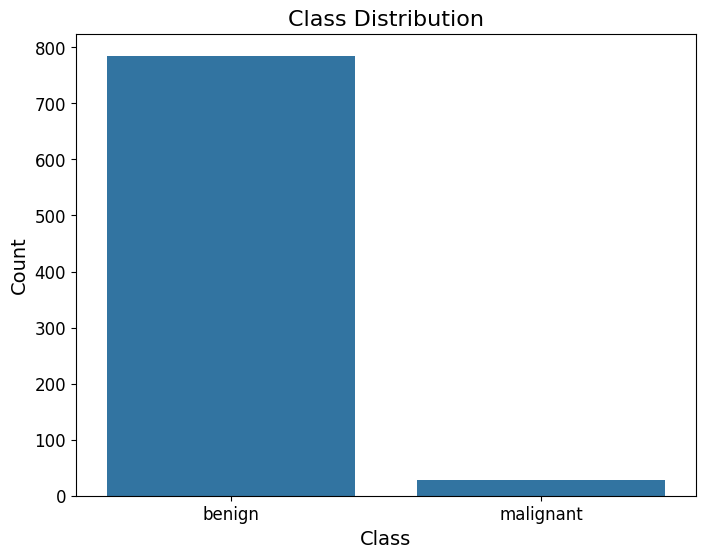

In [ ]:
data = pd.read_csv(csv_dir)
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], labels=['benign','malignant'], fontsize=12)
plt.yticks(fontsize=12)
plt.show()

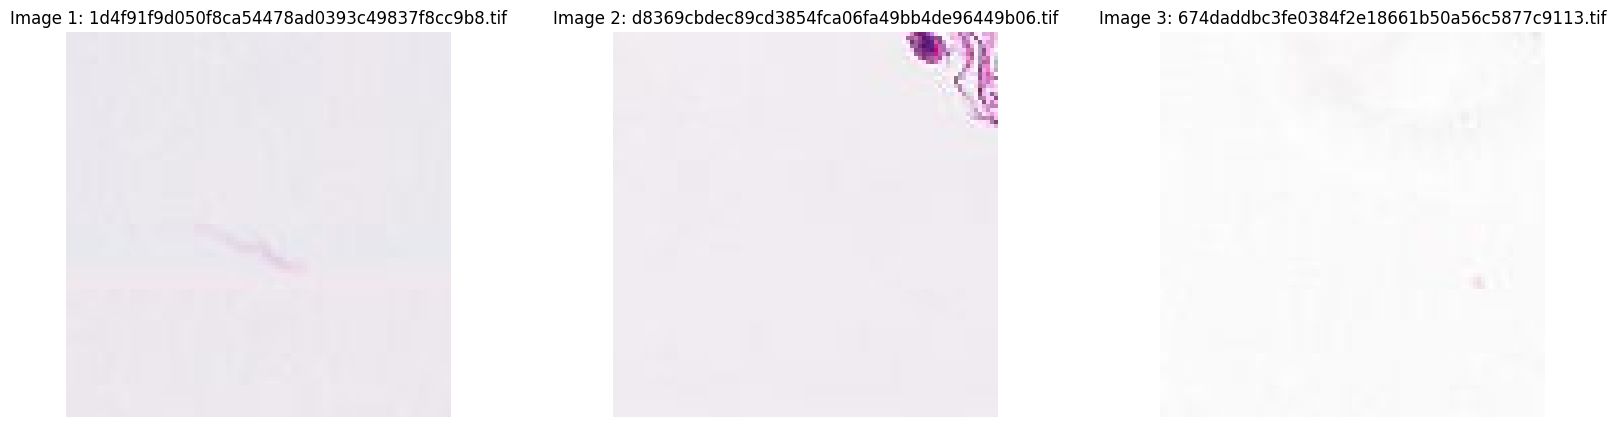

In [ ]:
image_files = os.listdir(img_dir)
num_images = 3
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

for i in range(min(num_images, len(image_files))):
    img_path = os.path.join(img_dir, image_files[i])
    image = cv2.imread(img_path)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}: {image_files[i]}")
plt.show()


# Custom CNN

In [ ]:
class Classifier_CNN(nn.Module):
    def __init__(self):
        super(Classifier_CNN, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

        self.relu = nn.ReLU()

    def forward(self, img):

        x = self.relu(self.bn1(self.conv1(img)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# Custom CNN Training

In [ ]:
train_losses_per_epoch_cnn = []
val_losses_per_epoch_cnn = []
val_accuracies_cnn = []
confusion_matrices_cnn = []

def train_net_cnn(net,
              device,
              epochs: int = 5,
              num_classes=2,
              batch_size: int = 32,
              learning_rate: float = 1e-5,
              val_percent: float = 0.1,
              save_checkpoint: bool = True,
              amp: bool = False):

    global train_losses_per_epoch_cnn, val_losses_per_epoch_cnn, val_accuracies_cnn, confusion_matrices_cnn

    # Data transformations
    data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(p=0.4),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Dataset and split
    dataset = CustomDataset(csv_dir, root_dir=img_dir, transform=data_transforms)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    loader_args = dict(batch_size=batch_size, num_workers=2, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=True, drop_last=True, **loader_args)

    # Model, optimizer, and scheduler
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, verbose=True)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()

    print(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

    for epoch in range(1, epochs + 1):
        # Training phase
        net.train()
        epoch_loss = 0
        total_correct = 0
        total_instances = 0

        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image'].to(device=device, dtype=torch.float32)
                true_class = batch['class'].to(device=device)

                with torch.cuda.amp.autocast(enabled=amp):
                    pred = net(images)
                    loss = criterion(pred, true_class)

                optimizer.zero_grad()
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                predictions = torch.argmax(pred, dim=1)
                correct_predictions = sum(predictions == true_class).item()
                total_correct += correct_predictions
                total_instances += len(images)

                pbar.update(images.shape[0])
                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        train_losses_per_epoch_cnn.append(epoch_loss / len(train_loader))
        train_accuracy = total_correct / total_instances
        print(f"Training Accuracy: {train_accuracy:.3f}")

        # Validation phase
        val_losses = []
        y_pred = []
        y_true = []
        total_correct = 0
        total_instances = 0

        net.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                images = batch['image'].to(device=device, dtype=torch.float32)
                true_class = batch['class'].to(device=device)

                pred = net(images)
                loss = criterion(pred, true_class)
                val_losses.append(loss.item())

                pred_classes = torch.argmax(pred, dim=1).cpu().tolist()
                true_classes = true_class.cpu().tolist()
                y_pred.extend(pred_classes)
                y_true.extend(true_classes)

                correct_predictions = sum(p == t for p, t in zip(pred_classes, true_classes))
                total_correct += correct_predictions
                total_instances += len(images)

        val_loss = np.mean(val_losses)
        val_accuracy = total_correct / total_instances
        val_losses_per_epoch_cnn.append(val_loss)
        val_accuracies_cnn.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.3f}")

        # Generate confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred, labels=range(num_classes))
        confusion_matrices_cnn.append(cf_matrix)  # Save for later visualization
        df_cm = pd.DataFrame(cf_matrix, index=[f"Class {i}" for i in range(num_classes)],
                             columns=[f"Class {i}" for i in range(num_classes)])
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Epoch {epoch}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(f'confusion_matrix_epoch{epoch}.png')
        plt.close()

        # Adjust learning rate
        scheduler.step(val_accuracy)

        # Save checkpoint
        if save_checkpoint:
            torch.save(net.state_dict(), f'checkpoint_epoch{epoch}.pth')

    print("Training complete.")


# DenseNet201 Classifier

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = models.densenet201(weights='DEFAULT')
        self.num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.num_ftrs, 2)
        self.soft = nn.Softmax()

    def forward(self, img):
        out = self.model(img)
        out = self.soft(out)
        return out

# DesnseNet Training

In [ ]:
train_losses_per_epoch = []
val_losses_per_epoch = []
val_accuracies = []
confusion_matrices = []

def train_net(net,
              device,
              epochs: int = 5,
              num_classes=2,
              batch_size: int = 32,
              learning_rate: float = 1e-5,
              val_percent: float = 0.1,
              save_checkpoint: bool = True,
              amp: bool = False):

    global train_losses_per_epoch, val_losses_per_epoch, val_accuracies, confusion_matrices

    # Data transformations
    data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(p=0.4),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Dataset and split
    dataset = CustomDataset(csv_dir, root_dir=img_dir, transform=data_transforms)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    loader_args = dict(batch_size=batch_size, num_workers=2, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=True, drop_last=True, **loader_args)

    # Model, optimizer, and scheduler
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, verbose=True)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()

    print(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

    for epoch in range(1, epochs + 1):
        # Training phase
        net.train()
        epoch_loss = 0
        total_correct = 0
        total_instances = 0

        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image'].to(device=device, dtype=torch.float32)
                true_class = batch['class'].to(device=device)

                with torch.cuda.amp.autocast(enabled=amp):
                    pred = net(images)
                    loss = criterion(pred, true_class)

                optimizer.zero_grad()
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                predictions = torch.argmax(pred, dim=1)
                correct_predictions = sum(predictions == true_class).item()
                total_correct += correct_predictions
                total_instances += len(images)

                pbar.update(images.shape[0])
                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        train_losses_per_epoch.append(epoch_loss / len(train_loader))
        train_accuracy = total_correct / total_instances
        print(f"Training Accuracy: {train_accuracy:.3f}")

        # Validation phase
        val_losses = []
        y_pred = []
        y_true = []
        total_correct = 0
        total_instances = 0

        net.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                images = batch['image'].to(device=device, dtype=torch.float32)
                true_class = batch['class'].to(device=device)

                pred = net(images)
                loss = criterion(pred, true_class)
                val_losses.append(loss.item())

                pred_classes = torch.argmax(pred, dim=1).cpu().tolist()
                true_classes = true_class.cpu().tolist()
                y_pred.extend(pred_classes)
                y_true.extend(true_classes)

                correct_predictions = sum(p == t for p, t in zip(pred_classes, true_classes))
                total_correct += correct_predictions
                total_instances += len(images)

        val_loss = np.mean(val_losses)
        val_accuracy = total_correct / total_instances
        val_losses_per_epoch.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.3f}")

        # Generate confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred, labels=range(num_classes))
        confusion_matrices.append(cf_matrix)  # Save for later visualization
        df_cm = pd.DataFrame(cf_matrix, index=[f"Class {i}" for i in range(num_classes)],
                             columns=[f"Class {i}" for i in range(num_classes)])
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Epoch {epoch}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(f'confusion_matrix_epoch{epoch}.png')
        plt.close()

        # Adjust learning rate
        scheduler.step(val_accuracy)

        # Save checkpoint
        if save_checkpoint:
            torch.save(net.state_dict(), f'checkpoint_epoch{epoch}.pth')

    print("Training complete.")

# Vizualization

In [ ]:
def plot_metrics():
    global train_losses_per_epoch_cnn, val_losses_per_epoch_cnn, val_accuracies_cnn
    global train_losses_per_epoch, val_losses_per_epoch, val_accuracies

    # Loss Cruve DenseNet
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_per_epoch, label='Train Loss')
    plt.plot(val_losses_per_epoch, label='Validation Loss')
    plt.title('Loss Per Epoch DenseNet')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_curve.png')
    plt.show()

    # Loss Curve CNN
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_per_epoch_cnn, label='Train Loss')
    plt.plot(val_losses_per_epoch_cnn, label='Validation Loss')
    plt.title('Loss Per Epoch Custom CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_curve_cnn.png')
    plt.show()


    # Accuracy Curve CNN
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies_cnn, label='Validation Accuracy')
    plt.title('Validation Accuracy Per Epoch for CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_curve_cnn.png')
    plt.show()
    # Acuracy Curve DenseNet
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy Per Epoch for DenseNet')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_curve.png')
    plt.show()

    # Accuracy Comparission
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies_cnn, label='CNN Validation Accuracy', color='blue')
    plt.plot(val_accuracies, label='DenseNet Validation Accuracy', color='orange')
    plt.title('Validation Accuracy Per Epoch for CNN and DenseNet')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('combined_accuracy_curve.png')
    plt.show()

    # Confusion Matrices
    last_epoch_index_cnn = len(confusion_matrices_cnn) - 1  # Index of the last epoch's CNN confusion matrix
    matrix_cnn = confusion_matrices_cnn[last_epoch_index_cnn]

    df_cm_cnn = pd.DataFrame(matrix_cnn, index=['benign', 'malignant'], columns=['benign', 'malignant'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm_cnn, annot=True, fmt='d', cmap='Blues')
    plt.title(f'CNN Confusion Matrix - Epoch {last_epoch_index_cnn + 1}')  # Epoch index is 1-based
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    last_epoch_index = len(confusion_matrices) - 1
    matrix_other = confusion_matrices[last_epoch_index]

    df_cm_other = pd.DataFrame(matrix_other, index=['benign', 'malignant'], columns=['benign', 'malignant'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm_other, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Other Model Confusion Matrix - Epoch {last_epoch_index + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Code Activation

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

net = Classifier().to(device)
#net_CNN = Classifier_CNN().to(device)

train_net(net, device, epochs=20, batch_size=128, learning_rate=0.0002, val_percent=0.2, amp=True)
#train_net_cnn(net_CNN, device, epochs=20, batch_size=128, learning_rate=0.0002, val_percent=0.2, amp=True)

Using GPU: Tesla T4


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 71.8MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-9-57abc2d4a43f>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)


Starting training:
        Epochs:          20
        Batch size:      128
        Learning rate:   0.0002
        Training size:   651
        Validation size: 162
        Checkpoints:     True
        Device:          cuda
        Mixed Precision: True
    


Epoch 1/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 1/20: 100%|██████████| 651/651 [00:27<00:00, 23.75img/s, loss=0.482]


Training Accuracy: 0.673


Validation Accuracy: 0.828


Epoch 2/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 2/20: 100%|██████████| 651/651 [00:04<00:00, 139.56img/s, loss=0.361]


Training Accuracy: 0.962


Validation Accuracy: 0.953


Epoch 3/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 3/20: 100%|██████████| 651/651 [00:04<00:00, 154.85img/s, loss=0.415]


Training Accuracy: 0.969


Validation Accuracy: 0.953


Epoch 4/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 4/20: 100%|██████████| 651/651 [00:06<00:00, 106.73img/s, loss=0.323]


Training Accuracy: 0.975


Validation Accuracy: 0.961


Epoch 5/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 5/20: 100%|██████████| 651/651 [00:04<00:00, 156.37img/s, loss=0.321]


Training Accuracy: 0.975


Validation Accuracy: 0.953


Epoch 6/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 6/20: 100%|██████████| 651/651 [00:05<00:00, 123.66img/s, loss=0.324]


Training Accuracy: 0.986


Validation Accuracy: 0.961


Epoch 7/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 7/20: 100%|██████████| 651/651 [00:04<00:00, 136.31img/s, loss=0.32]


Training Accuracy: 0.975


Validation Accuracy: 0.953


Epoch 8/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 8/20: 100%|██████████| 651/651 [00:04<00:00, 141.59img/s, loss=0.316]


Training Accuracy: 0.975


Validation Accuracy: 0.945


Epoch 9/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 9/20: 100%|██████████| 651/651 [00:05<00:00, 111.90img/s, loss=0.316]


Training Accuracy: 0.982


Validation Accuracy: 0.984


Epoch 10/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 10/20: 100%|██████████| 651/651 [00:04<00:00, 144.16img/s, loss=0.409]


Training Accuracy: 0.989


Validation Accuracy: 0.961


Epoch 11/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 11/20: 100%|██████████| 651/651 [00:05<00:00, 118.50img/s, loss=0.32]


Training Accuracy: 0.988


Validation Accuracy: 0.969


Epoch 12/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 12/20: 100%|██████████| 651/651 [00:04<00:00, 141.65img/s, loss=0.316]


Training Accuracy: 0.985


Validation Accuracy: 0.984


Epoch 13/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 13/20: 100%|██████████| 651/651 [00:04<00:00, 143.34img/s, loss=0.364]


Training Accuracy: 0.989


Validation Accuracy: 0.992


Epoch 14/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 14/20: 100%|██████████| 651/651 [00:04<00:00, 138.82img/s, loss=0.316]


Training Accuracy: 0.988


Validation Accuracy: 0.977


Epoch 15/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 15/20: 100%|██████████| 651/651 [00:04<00:00, 157.11img/s, loss=0.347]


Training Accuracy: 0.989


Validation Accuracy: 0.977


Epoch 16/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 16/20: 100%|██████████| 651/651 [00:05<00:00, 117.37img/s, loss=0.32]


Training Accuracy: 0.991


Validation Accuracy: 0.977


Epoch 17/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 17/20: 100%|██████████| 651/651 [00:04<00:00, 150.38img/s, loss=0.318]


Training Accuracy: 0.988


Validation Accuracy: 0.977


Epoch 18/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 18/20: 100%|██████████| 651/651 [00:06<00:00, 103.79img/s, loss=0.317]


Training Accuracy: 0.991


Validation Accuracy: 0.984


Epoch 19/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 19/20: 100%|██████████| 651/651 [00:04<00:00, 153.55img/s, loss=0.319]


Training Accuracy: 0.991


Validation Accuracy: 0.984


Epoch 20/20:   0%|          | 0/651 [00:00<?, ?img/s]<ipython-input-9-57abc2d4a43f>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 20/20: 100%|██████████| 651/651 [00:05<00:00, 124.99img/s, loss=0.402]


Training Accuracy: 0.988


Validation Accuracy: 0.977
Training complete.


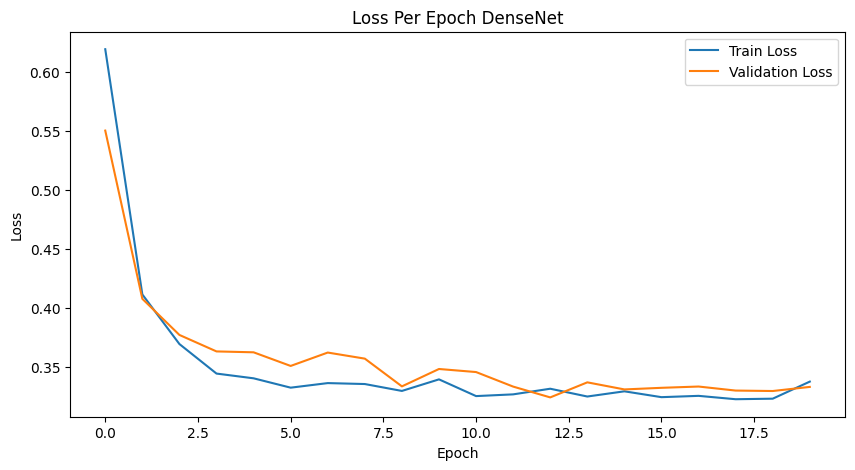

NameError: name 'train_losses_per_epoch_cnn' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
plot_metrics()